In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0512 05:26:19.535746 140157585950528 file_utils.py:38] PyTorch version 1.4.0 available.
I0512 05:26:19.536947 140157585950528 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 0


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
# model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased")

I0512 05:26:21.101170 140157585950528 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt from cache at /home/CompanyAI/.cache/torch/transformers/bb773818882b0524dc53a1b31a2cc95bc489f000e7e19773ba07846011a6c711.535306b226c42cebebbc0dabc83b92ab11260e9919e21e2ab0beb301f267b4c7


In [5]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 384
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 39
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [6]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[SEP]', '[PAD]', '[CLS]', '[MASK]', '[UNK]'] 
 [102, 0, 101, 103, 100]
[101, 1174, 26646, 49345, 13045, 35132, 25169, 47024, 117, 1170, 26646, 11376, 17360, 13212, 79427, 102]
[101, 29155, 10228, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] hello world [SEP]


# Korean Movie Review Classification

In [8]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

In [10]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in zip(train_data["document"], train_data["label"]):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(train_sent), MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

# sents: 149995, # labels: 149995


In [11]:
# Max length 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[  101  1181 49904 13503  1180 29347 63227 27884 12300  1177 29347 47087
 13045 30666 18539 18702 12397  1174 29347 40523 25763 13130 20766 23724
 20966 97076 46069 17360 12799  1174 25539 97096 16336 16801   102     0
     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나 [SEP] [PAD] [PAD] [PAD] [PAD]


In [12]:
class TFBertClassifier(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.num_labels = config.num_labels        
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        
        pooled_output = outputs[1]
#         pooled_output = outputs[0][:, -1]
    
        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return logits
    
cls_model = TFBertClassifier(BertConfig()).from_pretrained("bert-base-multilingual-uncased")

I0512 05:28:15.162854 140157585950528 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/CompanyAI/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc
I0512 05:28:15.164940 140157585950528 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  

In [13]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

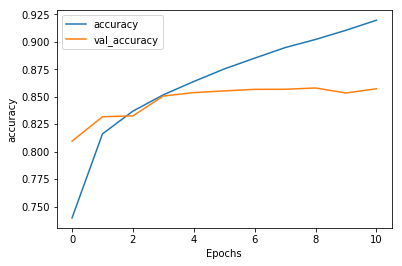

In [86]:
plot_graphs(history, 'accuracy')

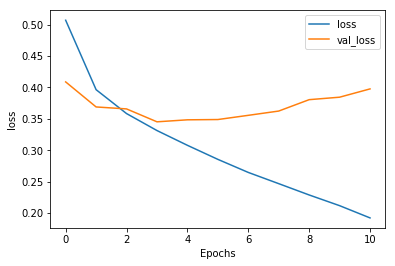

In [87]:
plot_graphs(history, 'loss')

# Korean Movie Review Test 데이터

In [88]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [89]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in zip(test_data["document"], test_data["label"]):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(test_sent), MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

num sents, labels 49997, 49997


In [90]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49997/49997 [==============================] - 40s 809us/sample - loss: 0.4035 - accuracy: 0.8533
test loss, test acc:  [0.4034854095686764, 0.8533112]


# KorNLI Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [15]:
# BASE PARAM

BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 40 * 2 # Average total * 2

In [16]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [17]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [18]:
# train_data_xnli = train_data_xnli[:100]

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)

# DEV SET Preprocessing

In [19]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)

In [20]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [21]:
class TFBertClassifier(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.num_labels = 3
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(self.num_labels, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        
        pooled_output = outputs[1]
    
        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return logits
    
cls_model = TFBertClassifier(BertConfig()).from_pretrained("bert-base-multilingual-uncased")

I0512 05:42:45.893804 140157585950528 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/CompanyAI/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc
I0512 05:42:45.895607 140157585950528 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  

In [22]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [23]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_xnli_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

data_out/KOR/tf2_KorNLI -- Folder already exists 

Train on 942808 samples, validate on 2490 samples
Epoch 1/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.7042
Epoch 00001: val_accuracy improved from -inf to 0.69679, saving model to data_out/KOR/tf2_KorNLI/weights.h5
942808/942808 [==============================] - 4946s 5ms/sample - loss: 0.6891 - accuracy: 0.7042 - val_loss: 0.7078 - val_accuracy: 0.6968
Epoch 2/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7596
Epoch 00002: val_accuracy improved from 0.69679 to 0.71727, saving model to data_out/KOR/tf2_KorNLI/weights.h5
942808/942808 [==============================] - 4932s 5ms/sample - loss: 0.5830 - accuracy: 0.7596 - val_loss: 0.6724 - val_accuracy: 0.7173
Epoch 3/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.5347 - accuracy: 0.7827
Epoch 00003: val_accuracy improved from 0.71727 to 0.72129, saving model to data_out/KOR/t

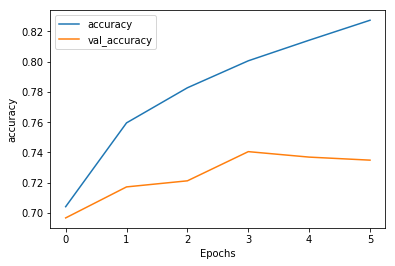

In [31]:
plot_graphs(history, 'accuracy')

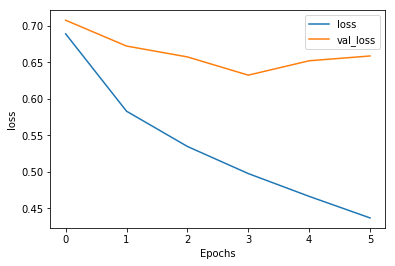

In [32]:
plot_graphs(history, 'loss')

# KorNLI Test dataset

In [26]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
test_data_xnli = test_data_xnli.dropna()
test_data_xnli.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


In [27]:
# Test set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
    
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)

In [28]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_xnli_input_ids), len(test_data_xnli_labels)))

# sents: 5010, # labels: 5010


In [30]:
results = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size=512)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 9s 2ms/sample - loss: 0.6741 - accuracy: 0.7305
test loss, test acc:  [0.6741368320411789, 0.7305389]


# Dev Validation 0.1

In [57]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_split = 0.1,
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

data_out/KOR/tf2_KorNLI -- Folder already exists 

Train on 848527 samples, validate on 94281 samples
Epoch 1/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8554
Epoch 00001: val_accuracy improved from -inf to 0.83723, saving model to data_out/KOR/tf2_KorNLI/weights.h5
848527/848527 [==============================] - 4634s 5ms/sample - loss: 0.3728 - accuracy: 0.8554 - val_loss: 0.4107 - val_accuracy: 0.8372
Epoch 2/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8663
Epoch 00002: val_accuracy did not improve from 0.83723
848527/848527 [==============================] - 4622s 5ms/sample - loss: 0.3465 - accuracy: 0.8663 - val_loss: 0.4311 - val_accuracy: 0.8278
Epoch 3/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8766
Epoch 00003: val_accuracy did not improve from 0.83723
848527/848527 [==============================] - 4625s 5ms/sample - loss: 0.3221 - accurac

In [61]:
results = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size=512)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 8s 2ms/sample - loss: 0.7548 - accuracy: 0.7259
test loss, test acc:  [0.7547728001714467, 0.7259481]


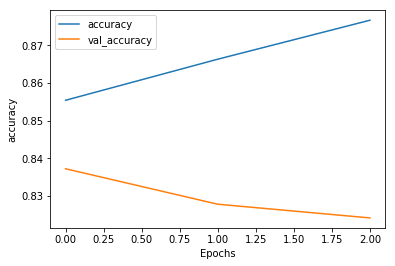

In [62]:
plot_graphs(history, 'accuracy')

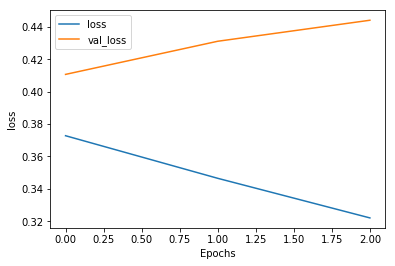

In [63]:
plot_graphs(history, 'loss')